# Tutorial on fitting with `ticktack` and `emcee`

Let's go through an example of how you would fit the original Miyake event time series from 774 AD ([Miyake et al, 2012](https://www.nature.com/articles/nature11123)) using tools from `ticktack`. First we import everything.

In [1]:
import numpy as np
import ticktack
from ticktack import fitting
from jax import jit
import jax.numpy as jnp

Now, we load a presaved model; `ticktack` currently has pre-saved reimplementations of the carbon box models from
['Guttler14'](https://www.sciencedirect.com/science/article/pii/S0012821X14007481?via%3Dihub#fg0030), ['Brehm21'](https://www.nature.com/articles/s41561-020-00674-0), ['Miyake17'](https://ui.adsabs.harvard.edu/abs/2017PNAS..114..881M/abstract), or ['Buntgen18'](https://www.nature.com/articles/s41467-018-06036-0#Sec12). 

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')

INFO[2021-11-24 19:02:32,311]: Starting the local TPU driver.
INFO[2021-11-24 19:02:32,312]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO[2021-11-24 19:02:32,313]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2021-11-24 19:02:32,314]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2021-11-24 19:02:32,314]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Now we initialize a `SingleFitter` object using this carbon box model, together with the data from Miyake et al, 2012. This will handle Bayesian inference of production rates conditioned on these data.

In [3]:
sf = fitting.SingleFitter(cbm)
sf.load_data('miyake12.csv')
sf.prepare_function(model="simple_sinusoid")

The default engine for sampling from this posterior is [emcee](https://emcee.readthedocs.io/en/stable/). We are working on implementing nested sampling and variational inference. We call `emcee` from a method of the `SingleFitter` object like this, where params are (arrival time in years, duration in years, solar cycle phase in radians, and total radiocarbon delivered in production rate times years).

In [4]:
%%time
default_params = np.array([775., 1./12, np.pi/2., 81./12])
sampler = sf.MarkovChainSampler(default_params, 
                                likelihood = sf.log_joint_simple_sinusoid, 
                                burnin = 500, 
                                production = 1000, 
                                args = (jnp.array([770., 0., -jnp.pi, 0.]),
                                jnp.array([780., 5., jnp.pi, 15.]))
                               )

Running burn-in...


100%|█████████████████████████████████████████| 500/500 [00:27<00:00, 18.28it/s]


Running production...


100%|███████████████████████████████████████| 1000/1000 [00:54<00:00, 18.47it/s]

CPU times: user 1min 26s, sys: 1.46 s, total: 1min 28s
Wall time: 1min 23s


Plot of posterior surface using [ChainConsumer](https://samreay.github.io/ChainConsumer/):

WARNING[2021-11-24 19:03:57,611]: Parameter phi (yr) in chain Chain 0 is not constrained


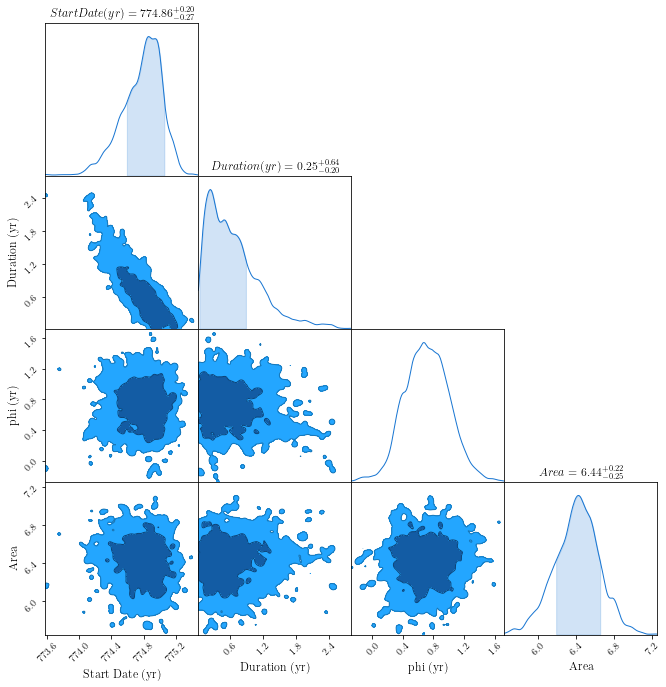

In [5]:
labels = ["Start Date (yr)", "Duration (yr)", "phi (yr)", "Area"]
fig = sf.chain_summary(sampler, 20, labels=labels)

And a plot of models evaluated from samples of the posterior parameters shows a pretty good fit!

WARNING[2021-11-24 19:04:01,543]: Parameter 2 in chain Chain 0 is not constrained


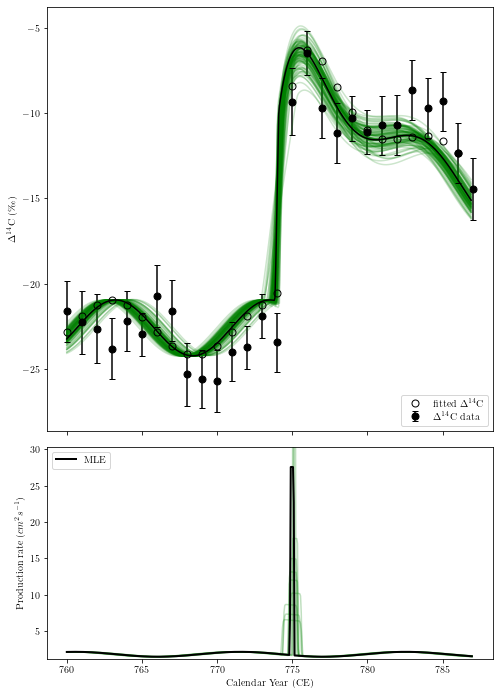

In [6]:
sf.plot_samples(sampler, 20)